%md 

# Estudo sobre os preços das listagens de Airbnb na cidade do Rio de Janeiro

Este projeto tem como objetivo analisar como o Airbnb está sendo utilizado na cidade do Rio de Janeiro através de dados fornecido pela próprio organização. Como resultado, temos a criação de um modelo de predição de preços baseado nas features mais relevantes. 

Os dados foram disponibilizados pelo Inside Airbnb - "[...] um conjunto independente e não comercial de ferramentas e dados que permitem que você explore como o Airbnb está realmente sendo usado em cidades ao redor do mundo".

Este projeto reforça a importância dos dados nas decisões dos negócios e como podemos tirar insights a partir dos mesmos para termos o melhor resultado possível na resolução de problemas. 

No início do estudo foram levantadas algumas hipóteses que serão investigadas durante este estudo. As hipóteses mais relevantes são:

- **Preços**: Considerando que o Estado do Rio de Janeiro é litorâneo, supõe-se que os preços da diária dos Airbnb são maiores quanto mais próximos estão localizados mais próximos do mar.

- **Features**: As features mais determinantes para o preço de um Airbnb se darão pela cidade no qual está localizado e com uma boa avaliação da locação e do anfitrião.

Para estas hipóteses, encontramos respostas baseada nos dados. 

*Falar sobre o Dataset aqui*


<br/>


# 1. Configurando o ambiente

In [1]:
# Rode apenas caso o seaborn não esteja instalado
%pip install -U seaborn

# Rode apenas caso o dython não esteja instalado
%pip install dython

# Rode apenas caso o foliun não esteja instalado
%pip install folium

In [61]:
# Realizando as importações 

import numpy as np

import pandas as pd

import seaborn as sns

from scipy import stats

from matplotlib import pyplot
import matplotlib.pyplot as plt

import folium
from folium.plugins import HeatMap

from dython.nominal import associations

from collections import Counter


In [3]:
# Configurando o seaborn

sns.set_style('whitegrid')

sns.color_palette("hls", 8)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

In [4]:
# Definição das constantes

AIRBNB_LISTINING_FILE_NAME = "listings.csv.gz"

DATASET_PATH = "https://raw.githubusercontent.com/joaovictordecastroa/airbnb-rio-de-janeiro-price-prediction/main/listings.csv.gz"

FILE_INITIAL = "file://"

OUTPUT_DATASET_PATH = "dbfs:/FileStore/Projects/Airbnb/airbnb-rio-de-janeiro-cleansed"

PLOT_DIMENSIONS = (25, 12.5)

MAIN_COLOR = "#1b48ab"

In [5]:
# Carregando e visualizando os Dataset 

raw_df = pd.read_csv(DATASET_PATH)

raw_df.head()

id  ... reviews_per_month
0  17878  ...              2.11
1  24480  ...              0.88
2  25026  ...              1.89
3  35636  ...              1.97
4  35764  ...              3.05

[5 rows x 74 columns]

# 3. Pré-processamento dos dados 

## 3.1. Seleção de feature

Quando procuramos um Airbnb, as informações básicas que são necessárias ter conhecimento é a o tipo de propriedade, ocupação sugerida/permitida, quantidade de quartos, banheiros, localização e claro, o preço da diária. Além disso, fatores como se o *Host* do Airbnb possui uma conta verificada, se é um *Super host*, a quantidade mínima de noites de permanência, se possui reserva instantânea, das avaliações gerais da locação como a nota do *Check-in*, limpeza, comunicação e cancelamento. Além disso, foi utilizado como base para seleção de features o dicionário disponibilizado pelo próprio Inside Airbnb cuja versão salva está disponibilizada [aqui](https://raw.githubusercontent.com/joaovictordecastroa/Aribnb-Rio-de-Janeiro-listining-price-prediction/main/Inside%20Airbnb%20Data%20Dictionary%20-%20listings.csv%20detail%20v4.csv).


In [6]:
columns_to_keep = [
  "host_is_superhost",
  "host_identity_verified",
  "host_has_profile_pic",
  "host_response_time",
  "host_response_rate",
  "host_acceptance_rate",
  "neighbourhood_cleansed",
  "latitude",
  "longitude",
  "property_type",
  "price",
  "room_type",
  "accommodates",
  "amenities",
  "bathrooms",
  "bathrooms_text",
  "bedrooms",
  "beds",
  "minimum_nights",
  "availability_30",
  "availability_60",
  "availability_90",
  "availability_365",
  "number_of_reviews",
  "review_scores_rating",
  "review_scores_accuracy",
  "review_scores_cleanliness",
  "review_scores_checkin",
  "review_scores_communication",
  "review_scores_location",
  "review_scores_value",
  "instant_bookable"
]

df = raw_df[columns_to_keep]

# Verificando o shape do dataframe após a filtragem de features

print("O novo dataset possui {} linhas e {} colunas.".format(df.shape[0], df.shape[1]))

df.head()

O novo dataset possui 23635 linhas e 32 colunas.


host_is_superhost  ... instant_bookable
0                 f  ...                t
1                 f  ...                f
2                 f  ...                f
3                 t  ...                f
4                 t  ...                f

[5 rows x 32 columns]

## 3.2. Resolvendo data types

Analisando o esquema dos dados gerados, será necessário fazer um cast dos valores do tipo integer para o tipo double devido aos métodos de Machine Learning que serão aplicados neste processo; 

In [7]:
# Visualizando os data types

df.dtypes

host_is_superhost               object
host_identity_verified          object
host_has_profile_pic            object
host_response_time              object
host_response_rate              object
host_acceptance_rate            object
neighbourhood_cleansed          object
latitude                       float64
longitude                      float64
property_type                   object
price                           object
room_type                       object
accommodates                     int64
amenities                       object
bathrooms                      float64
bathrooms_text                  object
bedrooms                       float64
beds                           float64
minimum_nights                   int64
availability_30                  int64
availability_60                  int64
availability_90                  int64
availability_365                 int64
number_of_reviews                int64
review_scores_rating           float64
review_scores_accuracy   

In [8]:
columns_to_parse = [
                    'price',
                    'host_response_rate',
                    'host_acceptance_rate',
                    'accommodates',
                    'beds',
                    'bedrooms',
                    'bathrooms',
                    'minimum_nights',
                    'availability_30',
                    'availability_60',
                    'availability_90',
                    'availability_365',
                    'number_of_reviews'
                   ] 

df[columns_to_parse] = df[columns_to_parse].replace(to_replace="\$|,|\%|\ ", value="", regex=True)

df['bathrooms'] = df['bathrooms_text'].replace(to_replace="(\s+)[a-zA-Z]+", value="", regex=True)

df[columns_to_parse] = df[columns_to_parse].apply(pd.to_numeric, errors='coerce')

df = df.drop('bathrooms_text', axis=1)

df.head()          

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


host_is_superhost  ... instant_bookable
0                 f  ...                t
1                 f  ...                f
2                 f  ...                f
3                 t  ...                f
4                 t  ...                f

[5 rows x 31 columns]

In [9]:
# Visualizando os novos data types

df.dtypes

host_is_superhost               object
host_identity_verified          object
host_has_profile_pic            object
host_response_time              object
host_response_rate             float64
host_acceptance_rate           float64
neighbourhood_cleansed          object
latitude                       float64
longitude                      float64
property_type                   object
price                          float64
room_type                       object
accommodates                     int64
amenities                       object
bathrooms                      float64
bedrooms                       float64
beds                           float64
minimum_nights                   int64
availability_30                  int64
availability_60                  int64
availability_90                  int64
availability_365                 int64
number_of_reviews                int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness

## 3.3. Tratando outliers

Para os nossos dadados iremos remover os outliers dos preços.

In [10]:
# Visualizando os dados estatísticos das features contínuas

df.select_dtypes(include=np.number).describe()

host_response_rate  ...  review_scores_value
count        14237.000000  ...         14501.000000
mean            80.516541  ...             4.630632
std             34.022200  ...             0.510273
min              0.000000  ...             1.000000
25%             80.000000  ...             4.500000
50%            100.000000  ...             4.750000
75%            100.000000  ...             5.000000
max            100.000000  ...             5.000000

[8 rows x 22 columns]

Verificamos que apenas os preços possuem uma grande discrepância nos valores com um valor máximo de *price* de  586229.0 reais e com uma variância de 5477 reais. 

In [11]:
# Calculando a média e o desvio padrão do preço

price_mean = df['price'].mean()
price_std = df['price'].std()

# Identificando Outliers

cut_off = price_std * 3

price_lower_limit = price_mean - cut_off if price_mean - cut_off > 0 else 0 

price_upper_limit = price_mean + cut_off

print(f'Limite superior para o preço: {price_upper_limit}')
print(f'Limite inferior para o preço: {price_lower_limit}')

Limite superior para o preço: 17182.95123563486
Limite inferior para o preço: 0


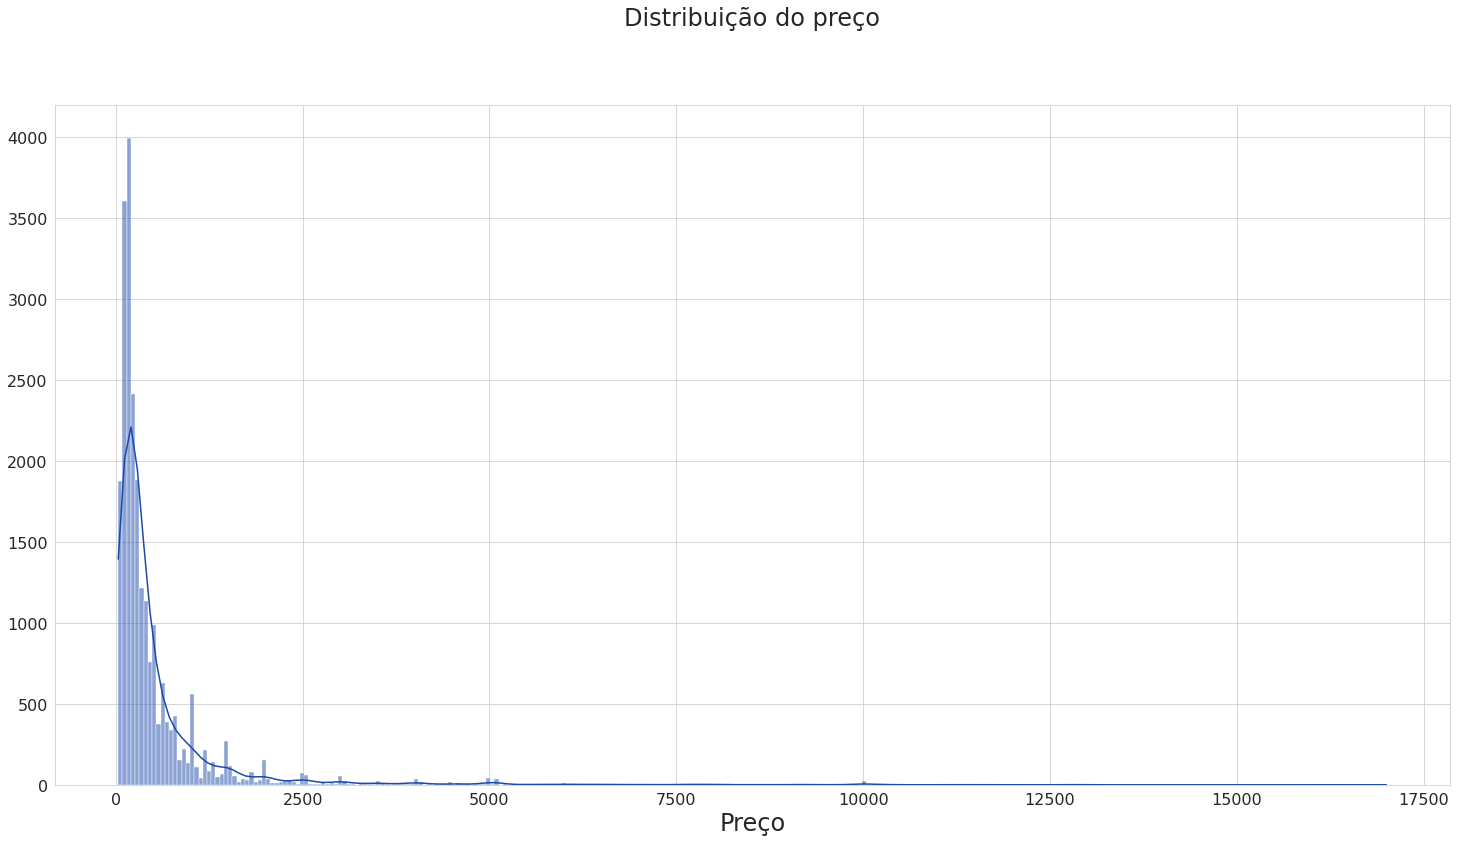

In [12]:
# Visualizando a distribuição dos preçeos considerando o limite superior e inferior designado

fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

hist_price_df = df[(df['price'] <= price_upper_limit) & (df['price'] > price_lower_limit)]

sns.histplot(data=hist_price_df["price"], color=MAIN_COLOR, ax=ax, kde=True, bins=300)

plt.xlabel("Preço", fontsize=24)

plt.ylabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Distribuição do preço", pad=80, fontsize=24)

plt.show()



Com isso percebemos que o preço possui uma densidade considerável até o valor de R$ 3.000 a diária, valores acima possuem pouca probabilidade de existir nesse dataset e serão considerados outliers.

In [13]:
# Filtrando o dataset com base em valores mínimos maiores do que zero e o preço baseado no limite superior

price_upper_limit = 3000

filtered_df = df[
                 (df['bathrooms'] > 0) |
                 (df['beds'] > 0) |
                 (df['bedrooms'] > 0) |
                 (df['number_of_reviews'] > 0)
                ]

filtered_df = filtered_df[(filtered_df['price'] > price_lower_limit) & (filtered_df['price'] <= price_upper_limit)]

filtered_df.describe()

host_response_rate  ...  review_scores_value
count        13909.000000  ...         14362.000000
mean            80.683658  ...             4.631257
std             33.953296  ...             0.510345
min              0.000000  ...             1.000000
25%             80.000000  ...             4.500000
50%            100.000000  ...             4.750000
75%            100.000000  ...             5.000000
max            100.000000  ...             5.000000

[8 rows x 22 columns]

## 3.4. Tratando valores nulos

Para que possamos trabalhar somente com dados válidos, iremos remover os valores nulos de features determinantes para um bom modelo de predição.

In [14]:
# Visualizando a porcentagem de valores nulos 

percent_missing = filtered_df.isnull().sum() * 100 / len(df)

missing_value_df = pd.DataFrame({'column_name': filtered_df.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values("percent_missing", ascending=False)

column_name  percent_missing
host_response_time                    host_response_time        38.481066
host_response_rate                    host_response_rate        38.481066
review_scores_location            review_scores_location        36.568648
review_scores_value                  review_scores_value        36.564417
review_scores_checkin              review_scores_checkin        36.564417
review_scores_accuracy            review_scores_accuracy        36.564417
review_scores_cleanliness      review_scores_cleanliness        36.560186
review_scores_communication  review_scores_communication        36.555955
host_acceptance_rate                host_acceptance_rate        36.454411
review_scores_rating                review_scores_rating        34.588534
bedrooms                                        bedrooms         6.587688
beds                                                beds         0.901206
bathrooms                                      bathrooms         0.317326
host_identity_verified            host_identity_verified         0.025386
host_is_superhost                      host_is_superhost         0.025386
host_has_profile_pic                host_has_profile_pic         0.025386
amenities                                      amenities         0.000000
accommodates                                accommodates         0.000000
minimum_nights                            minimum_nights         0.000000
availability_30                          availability_30         0.000000
availability_60                          availability_60         0.000000
availability_90                          availability_90         0.000000
availability_365                        availability_365         0.000000
number_of_reviews                      number_of_reviews         0.000000
room_type                                      room_type         0.000000
price                                              price         0.000000
property_type                              property_type         0.000000
longitude                                      longitude         0.000000
latitude                                        latitude         0.000000
neighbourhood_cleansed            neighbourhood_cleansed         0.000000
instant_bookable                        instant_bookable         0.000000

In [15]:
columns_to_filter_nulls = [
  "neighbourhood_cleansed",
  "latitude",
  "longitude",
  "number_of_reviews",
  "bedrooms",
  "beds",
  "bathrooms"
]

# Removendo os dados que não possuem valor válido da lista das colunas apontadas
filtered_df = filtered_df.dropna(subset=columns_to_filter_nulls)

In [16]:
columns_to_fill_nulls = [
                          "host_is_superhost",
                          "host_identity_verified",
                          "host_has_profile_pic"
                       ]

filtered_df[columns_to_fill_nulls] = filtered_df[columns_to_fill_nulls].fillna('f')

In [17]:
# Visualizando a porcentagem de valores nulos após a tratativa

percent_missing = filtered_df.isnull().sum() * 100 / len(df)

missing_value_df = pd.DataFrame({'column_name': filtered_df.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values("percent_missing", ascending=False)

column_name  percent_missing
host_response_time                    host_response_time        35.794373
host_response_rate                    host_response_rate        35.794373
host_acceptance_rate                host_acceptance_rate        34.089274
review_scores_location            review_scores_location        33.661942
review_scores_checkin              review_scores_checkin        33.657711
review_scores_value                  review_scores_value        33.657711
review_scores_accuracy            review_scores_accuracy        33.657711
review_scores_cleanliness      review_scores_cleanliness        33.653480
review_scores_communication  review_scores_communication        33.649249
review_scores_rating                review_scores_rating        31.834144
availability_365                        availability_365         0.000000
availability_60                          availability_60         0.000000
availability_90                          availability_90         0.000000
host_is_superhost                      host_is_superhost         0.000000
number_of_reviews                      number_of_reviews         0.000000
minimum_nights                            minimum_nights         0.000000
availability_30                          availability_30         0.000000
bedrooms                                        bedrooms         0.000000
beds                                                beds         0.000000
host_identity_verified            host_identity_verified         0.000000
bathrooms                                      bathrooms         0.000000
amenities                                      amenities         0.000000
accommodates                                accommodates         0.000000
room_type                                      room_type         0.000000
price                                              price         0.000000
property_type                              property_type         0.000000
longitude                                      longitude         0.000000
latitude                                        latitude         0.000000
neighbourhood_cleansed            neighbourhood_cleansed         0.000000
host_has_profile_pic                host_has_profile_pic         0.000000
instant_bookable                        instant_bookable         0.000000

## 3.5. Imputando dados

Após ter removido alguns valores nulos, iremos imputar valores para as notas de revisão dos usuários para ter uma maior assertividade dos dados na hora de criar o modelo. O método a ser utilizado para o impute será a média. 

In [18]:
impute_cols = [
  "review_scores_accuracy",
  "review_scores_cleanliness",
  "review_scores_checkin",
  "review_scores_communication",
  "review_scores_location",
  "review_scores_value",
  "host_response_rate",
  "host_acceptance_rate"
]

for c in impute_cols:
  print("Criação da coluna {}".format(c + "_na"))
  filtered_df[c + "_na"] = filtered_df[c].isna().astype(int)
  filtered_df[c] = filtered_df[c].fillna(filtered_df[c].mean())

Criação da coluna review_scores_accuracy_na
Criação da coluna review_scores_cleanliness_na
Criação da coluna review_scores_checkin_na
Criação da coluna review_scores_communication_na
Criação da coluna review_scores_location_na
Criação da coluna review_scores_value_na
Criação da coluna host_response_rate_na
Criação da coluna host_acceptance_rate_na


In [19]:
# Visualizando os dados com as novas colunas 

filtered_df.head()

host_is_superhost  ... host_acceptance_rate_na
0                 f  ...                       0
1                 f  ...                       1
2                 f  ...                       0
3                 t  ...                       1
4                 t  ...                       0

[5 rows x 39 columns]

## Transformando a coluna amenities em sub-features 



In [20]:
# Capturando as 30 comodidades mais recorrentes no Dataset

counter_results = Counter()


filtered_df['amenities'].str.strip('[]')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.lower()\
               .str.split(',')\
               .apply(counter_results.update)

# Visualizando as comodidades mais recorrentes com sua frequência no dataset

sub_df = pd.DataFrame(counter_results.most_common(30), columns=['amenity', 'count'])

sub_df.head(30)

amenity  count
0                          wifi  18865
1       long term stays allowed  17930
2                    essentials  17810
3              air conditioning  16769
4                       kitchen  14521
5                          iron  14161
6                        washer  13394
7                      elevator  13170
8           dedicated workspace  11976
9                       hangers  11616
10                    hot water  11582
11        dishes and silverware  10418
12                           tv  10270
13                 refrigerator   9150
14                   hair dryer   8963
15               cooking basics   8756
16                    microwave   8733
17     free parking on premises   8184
18                        stove   8005
19                 coffee maker   7817
20       tv with standard cable   7708
21                     cable tv   7607
22                         oven   7055
23            fire extinguisher   5861
24   extra pillows and blankets   5105
25      luggage dropoff allowed   4794
26                      kitchen   4760
27                   bed linens   4527
28              host greets you   4239
29             private entrance   4181

In [21]:
# Inserindo as novas colunas relativos às comodiadades selecionadas que recebe 'true' caso essa comodidade esteja listada no Airbnb e 'false' caso contrário

for index, row in sub_df.iterrows():
  column_name = row["amenity"].strip().replace(' ', '_')
  
  feature_like = row["amenity"].strip().lower()
  
  filtered_df[column_name] = filtered_df["amenities"].str.contains(feature_like, case=False).astype(int)
  
  print('Coluna {} inserida!'.format(column_name))
    


Coluna wifi inserida!
Coluna long_term_stays_allowed inserida!
Coluna essentials inserida!
Coluna air_conditioning inserida!
Coluna kitchen inserida!
Coluna iron inserida!
Coluna washer inserida!
Coluna elevator inserida!
Coluna dedicated_workspace inserida!
Coluna hangers inserida!
Coluna hot_water inserida!
Coluna dishes_and_silverware inserida!
Coluna tv inserida!
Coluna refrigerator inserida!
Coluna hair_dryer inserida!
Coluna cooking_basics inserida!
Coluna microwave inserida!
Coluna free_parking_on_premises inserida!
Coluna stove inserida!
Coluna coffee_maker inserida!
Coluna tv_with_standard_cable inserida!
Coluna cable_tv inserida!
Coluna oven inserida!
Coluna fire_extinguisher inserida!
Coluna extra_pillows_and_blankets inserida!
Coluna luggage_dropoff_allowed inserida!
Coluna kitchen inserida!
Coluna bed_linens inserida!
Coluna host_greets_you inserida!
Coluna private_entrance inserida!


In [22]:
# Visualizando o dataset com as novas colunas

filtered_df.head()

host_is_superhost host_identity_verified  ... host_greets_you private_entrance
0                 f                      t  ...               0                1
1                 f                      t  ...               0                0
2                 f                      t  ...               0                0
3                 t                      t  ...               0                0
4                 t                      f  ...               0                0

[5 rows x 68 columns]

In [23]:
cleaned_df = filtered_df.drop("amenities", axis=1)

cleaned_df.head()

host_is_superhost host_identity_verified  ... host_greets_you private_entrance
0                 f                      t  ...               0                1
1                 f                      t  ...               0                0
2                 f                      t  ...               0                0
3                 t                      t  ...               0                0
4                 t                      f  ...               0                0

[5 rows x 67 columns]

# 4. Explorando os dados



In [24]:
airbnb_df = cleaned_df.copy()

airbnb_df.describe()

host_response_rate  ...  private_entrance
count        21192.000000  ...      21192.000000
mean            80.672636  ...          0.197669
std             26.320227  ...          0.398250
min              0.000000  ...          0.000000
25%             80.672636  ...          0.000000
50%             80.672636  ...          0.000000
75%            100.000000  ...          0.000000
max            100.000000  ...          1.000000

[8 rows x 59 columns]

## 4.1. Analisando as features categóricas 



### 4.1.1. Analisando os tipos de quarto


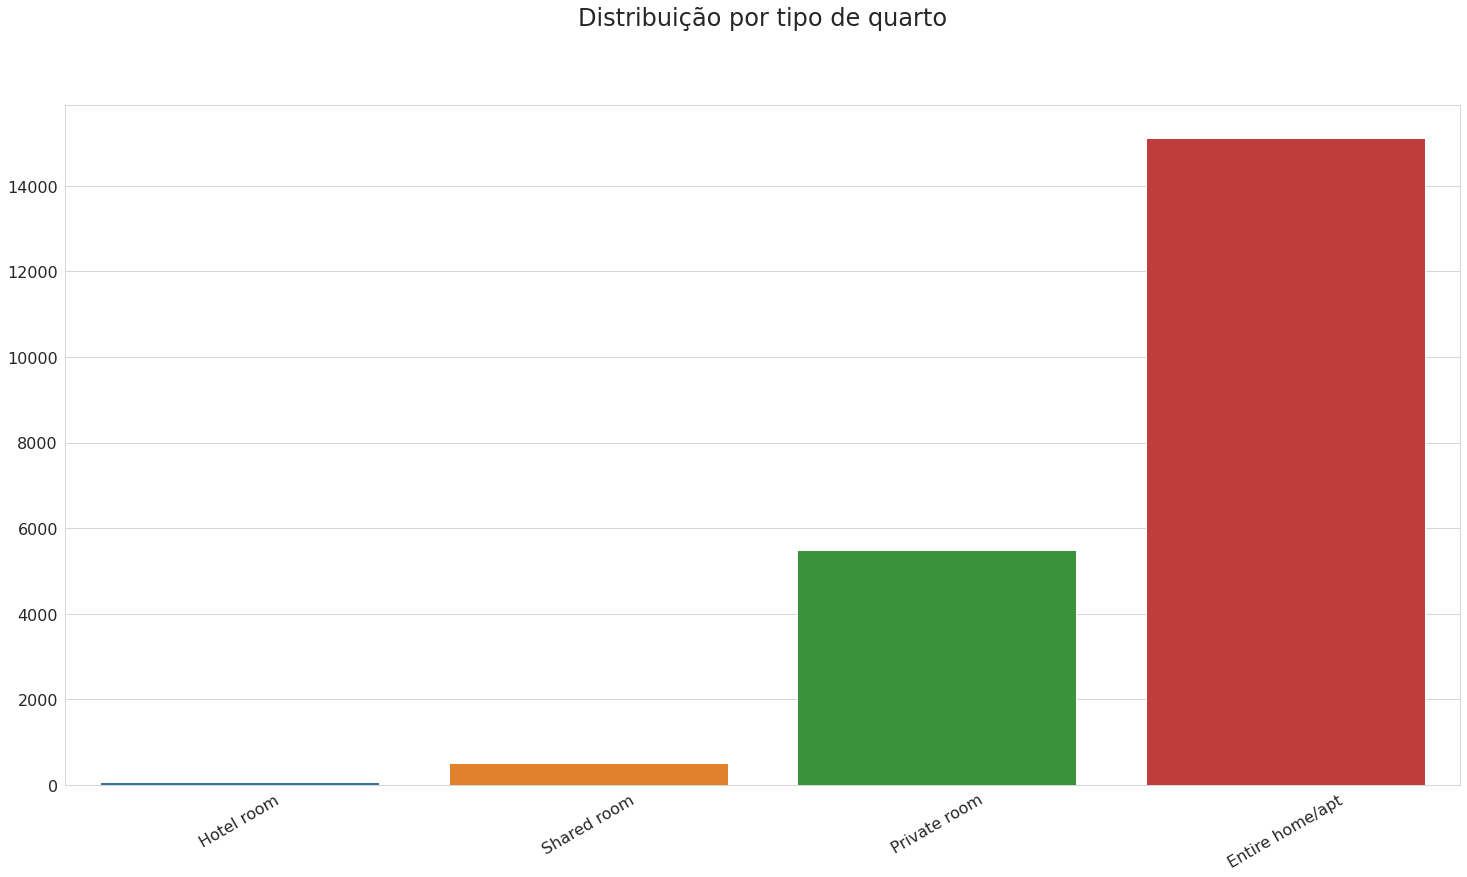

In [25]:
# Visualizando os tipos de quarto

room_type_count = airbnb_df.groupby("room_type") \
                           .count() \
                           .reset_index() \
                           .sort_values(by="host_is_superhost")[["room_type", "host_is_superhost"]]

room_type_count.columns = ["room_type", "count"]

fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

sns.barplot(x="room_type", y="count", data=room_type_count, ax=ax)

plt.xlabel("")

plt.ylabel("")

plt.xticks(fontsize=16, rotation=30, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Distribuição por tipo de quarto", pad=80, fontsize=24)

plt.show()


In [26]:
room_type_count.head()

room_type  count
1       Hotel room     67
3      Shared room    511
2     Private room   5491
0  Entire home/apt  15123

### 4.1.2. Analisando os tipos de propriedade

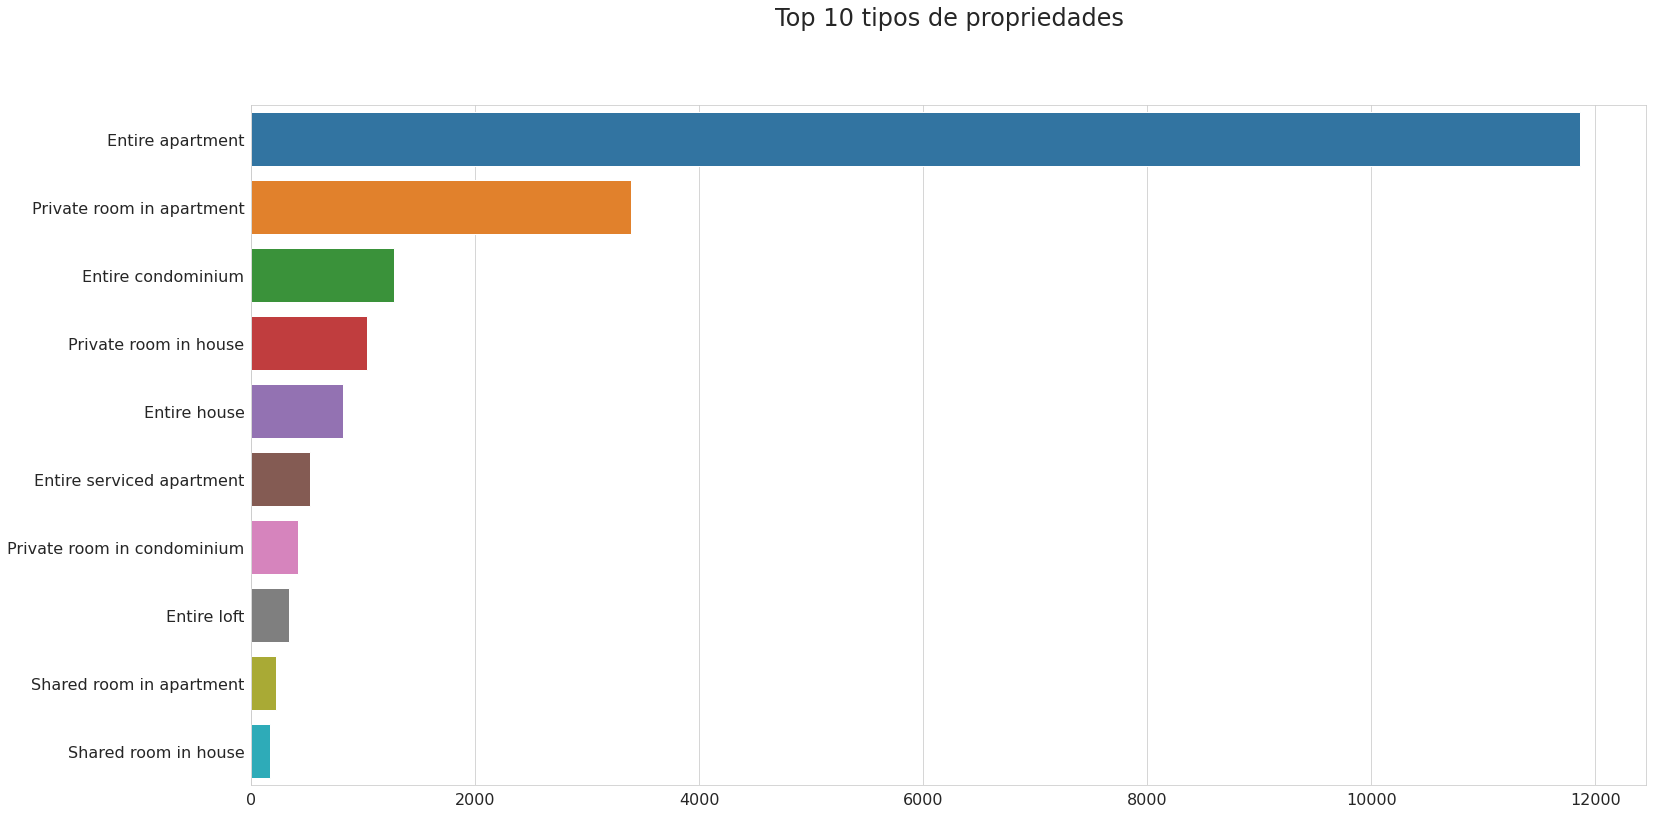

In [27]:
#  Visualizando os tipos de propriedade


property_type_count = airbnb_df.groupby("property_type") \
                               .count() \
                               .reset_index() \
                               .sort_values(by="host_is_superhost", ascending=False)[["property_type", "host_is_superhost"]]

property_type_count.columns = ["property_type", "count"]

fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

sns.barplot(y="property_type", x="count", data=property_type_count[:10], ax=ax)

plt.xlabel("")

plt.ylabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Top 10 tipos de propriedades", pad=80, fontsize=24)

plt.show()

In [28]:
#  Visualizando os tipos de propriedade

property_type_count

property_type  count
5            Entire apartment  11865
26  Private room in apartment   3393
10         Entire condominium   1273
43      Private room in house   1033
16               Entire house    815
..                        ...    ...
29       Private room in boat      1
31      Private room in cabin      1
51  Private room in treehouse      1
48       Private room in tent      1
83                       Yurt      1

[84 rows x 2 columns]

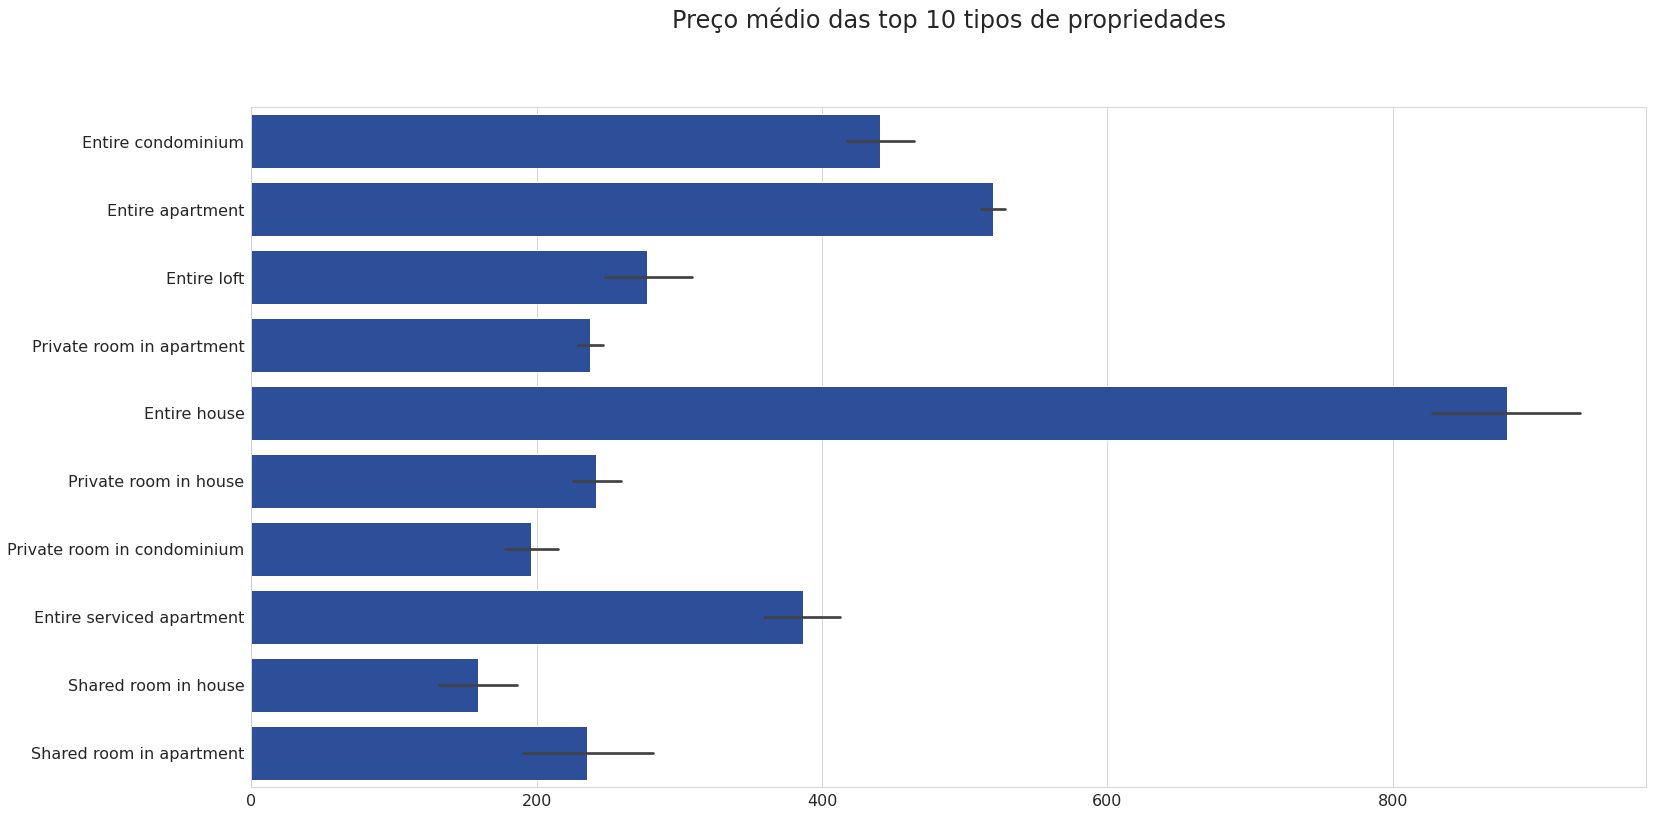

In [29]:
# Visualizando o preço médio do top 10 tipos de propriedade

fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

sns.barplot(
            y="property_type",
            x="price",
            data=airbnb_df[airbnb_df['property_type'].isin(property_type_count[:10]['property_type'])],
            color=MAIN_COLOR,
            ax=ax,
            orient='h',
            )

plt.xlabel("")

plt.ylabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Preço médio das top 10 tipos de propriedades", pad=80, fontsize=24)

plt.show()

In [30]:
# Visualizando o preço médio por tipo de propriedades

airbnb_df.groupby('property_type') \
  .mean() \
  .reset_index()[['property_type', 'price']]
  

property_type        price
0                       Boat  2166.666667
1                  Camper/RV   250.000000
2                   Campsite   875.000000
3     Casa particular (Cuba)   468.277778
4                Earth house   262.428571
..                       ...          ...
79  Shared room in townhouse    60.000000
80      Shared room in villa    82.250000
81                Tiny house   133.062500
82                 Treehouse   260.000000
83                      Yurt   300.000000

[84 rows x 2 columns]

### 4.1.3. Analisando a distribuição por bairro

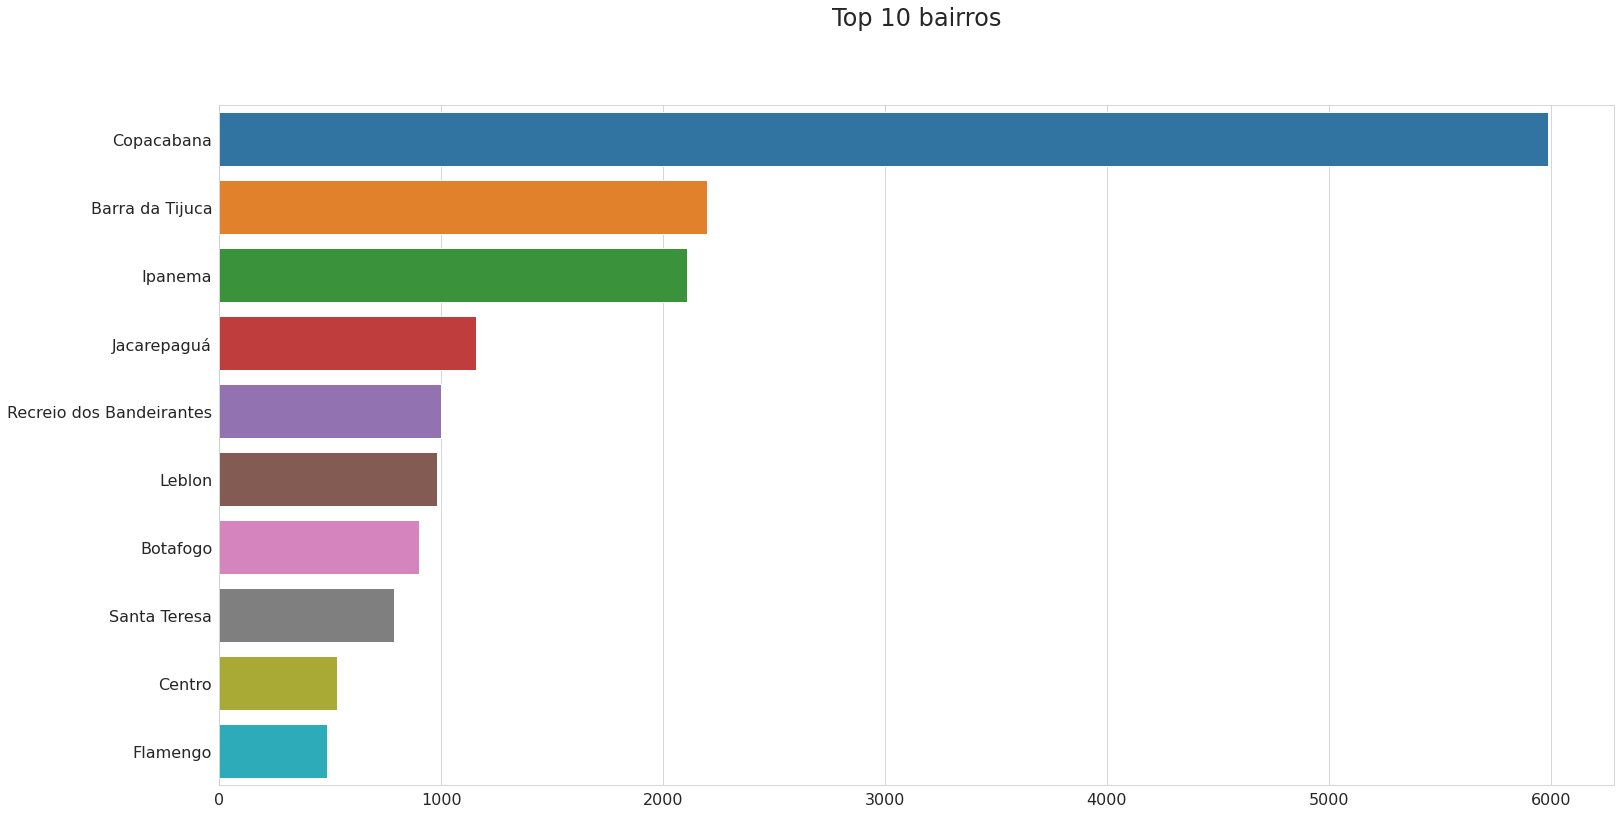

In [31]:
#  Visualizando a distribuição de Airbnb por bairro

neighbourhood_cleansed_count = airbnb_df.groupby("neighbourhood_cleansed") \
                                        .count() \
                                        .reset_index() \
                                        .sort_values("host_is_superhost", ascending=False)[["neighbourhood_cleansed", "host_is_superhost"]]

neighbourhood_cleansed_count.columns = ["neighbourhood_cleansed", "count"]

fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

sns.barplot(y="neighbourhood_cleansed", x="count", data=neighbourhood_cleansed_count[:10], orient='h')

plt.xlabel("")

plt.ylabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Top 10 bairros", pad=80, fontsize=24)

plt.show()

In [32]:
neighbourhood_cleansed_count

neighbourhood_cleansed  count
33                 Copacabana   5987
8             Barra da Tijuca   2200
63                    Ipanema   2109
66                Jacarepaguá   1155
110  Recreio dos Bandeirantes    998
..                        ...    ...
80           Magalhães Bastos      1
1                       Acari      1
67                Jacarezinho      1
39                    Deodoro      1
18                       Caju      1

[152 rows x 2 columns]

Visualizando um mapa de calor que evidencia os locais em que possuem a maior concentração de Airbnbs.


In [33]:
# Preparando uma matriz de latitude e longitude

lat = airbnb_df.latitude.tolist()

lng = airbnb_df.longitude.tolist()

In [34]:
# Visualizando um mapa de calor que evidencia os locais em que possuem a maior concentração de Airbnbs


rio_map = folium.Map([-22.9032, -43.1929], zoom_start=12) 

HeatMap(list(zip(lat, lng)), radius=10, gradient={0.2:'green',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(rio_map)


rio_map

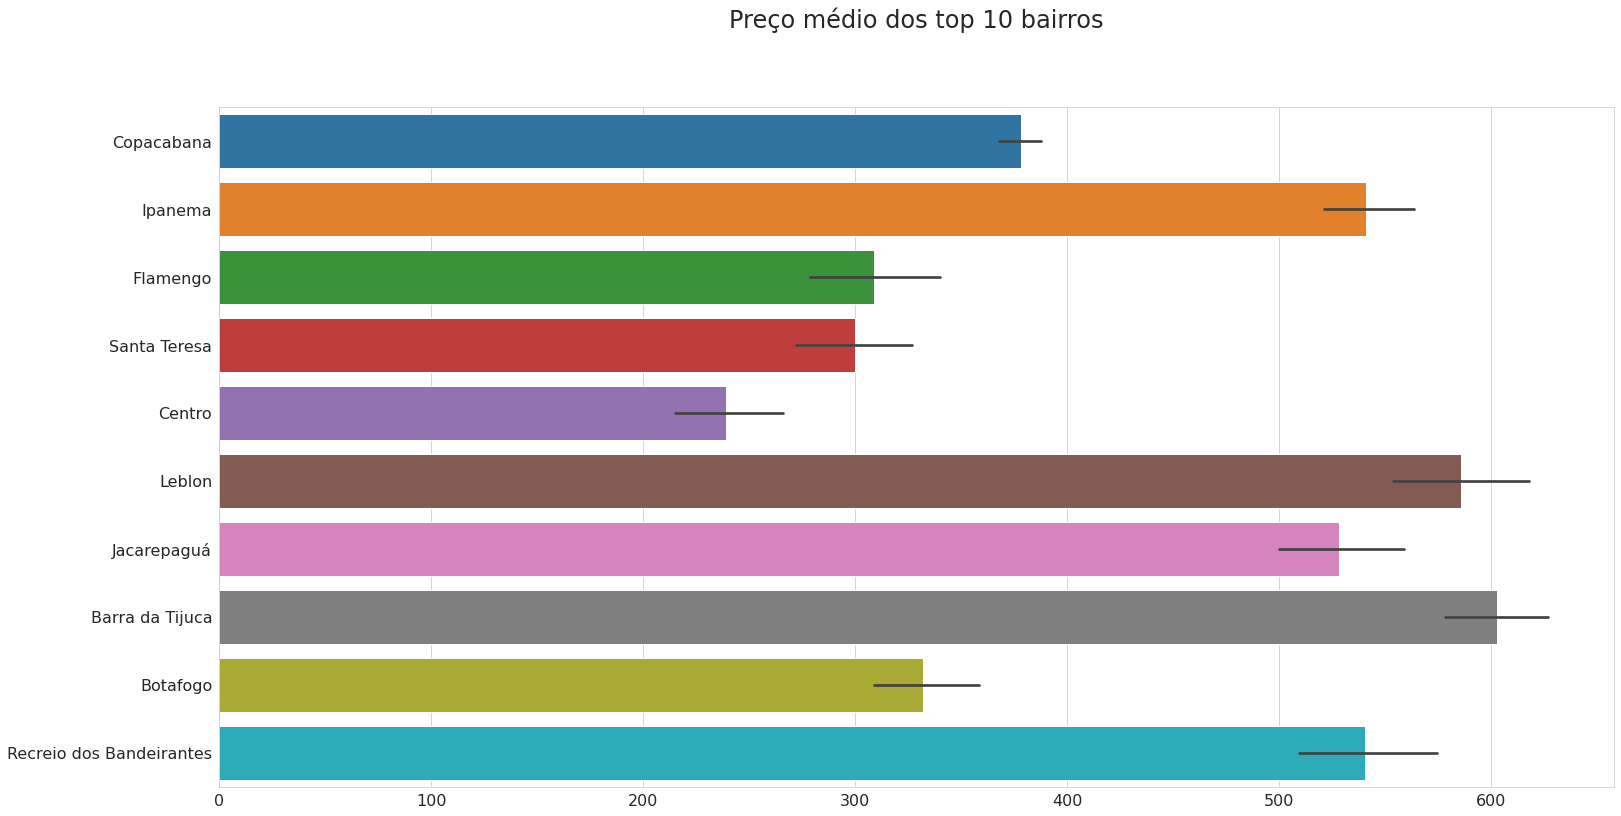

In [35]:
# Visualizando o preço médio dos top 10 bairros

fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

sns.barplot(
            y="neighbourhood_cleansed",
            x="price",
            data=airbnb_df[airbnb_df['neighbourhood_cleansed'].isin(neighbourhood_cleansed_count[:10]['neighbourhood_cleansed'])],
            ax=ax
            )

plt.xlabel("")

plt.ylabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Preço médio dos top 10 bairros", pad=80, fontsize=24)

plt.show()

In [41]:
# Visualizando o preço médio por bairro

airbnb_df.groupby('neighbourhood_cleansed') \
  .mean() \
  .reset_index()[['neighbourhood_cleansed', 'price']]


neighbourhood_cleansed       price
0                 Abolição  339.000000
1                    Acari  250.000000
2        Alto da Boa Vista  772.000000
3                 Anchieta  800.000000
4                  Andaraí  389.756757
..                     ...         ...
147         Vila Valqueire  436.785714
148          Vila da Penha  138.750000
149           Vista Alegre   50.000000
150                  Zumbi  149.000000
151             Água Santa  340.000000

[152 rows x 2 columns]

In [40]:
# Analisando os dados estatísticos dos preços dos Airbnbs por cidade

airbnb_df.groupby('neighbourhood_cleansed').price.describe()

count        mean         std  ...    50%     75%     max
neighbourhood_cleansed                                 ...                       
Abolição                  3.0  339.000000  399.713648  ...  128.0   464.0   800.0
Acari                     1.0  250.000000         NaN  ...  250.0   250.0   250.0
Alto da Boa Vista        27.0  772.000000  703.758755  ...  604.0  1193.0  2500.0
Anchieta                  1.0  800.000000         NaN  ...  800.0   800.0   800.0
Andaraí                  37.0  389.756757  579.717336  ...  150.0   400.0  2778.0
...                       ...         ...         ...  ...    ...     ...     ...
Vila Valqueire           14.0  436.785714  361.135640  ...  307.0   737.5  1000.0
Vila da Penha             8.0  138.750000   86.069324  ...  109.0   150.0   332.0
Vista Alegre              1.0   50.000000         NaN  ...   50.0    50.0    50.0
Zumbi                     1.0  149.000000         NaN  ...  149.0   149.0   149.0
Água Santa                2.0  340.000000  226.274170  ...  340.0   420.0   500.0

[152 rows x 8 columns]

In [45]:
# Visualizando um mapa de calor que evidencia as localizações com os maiores preços

rio_map = folium.Map([-22.9032, -43.1929], zoom_start=12) 

HeatMap(list(zip(lat, lng, airbnb_df.price)), 
       radius=10, gradient={0.2:'green',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(rio_map)

rio_map


### 4.1.4 Analisando correlação das features categóricas 

Analisando a correlação das variáveis categóricas utilizando o método Cramer's V.

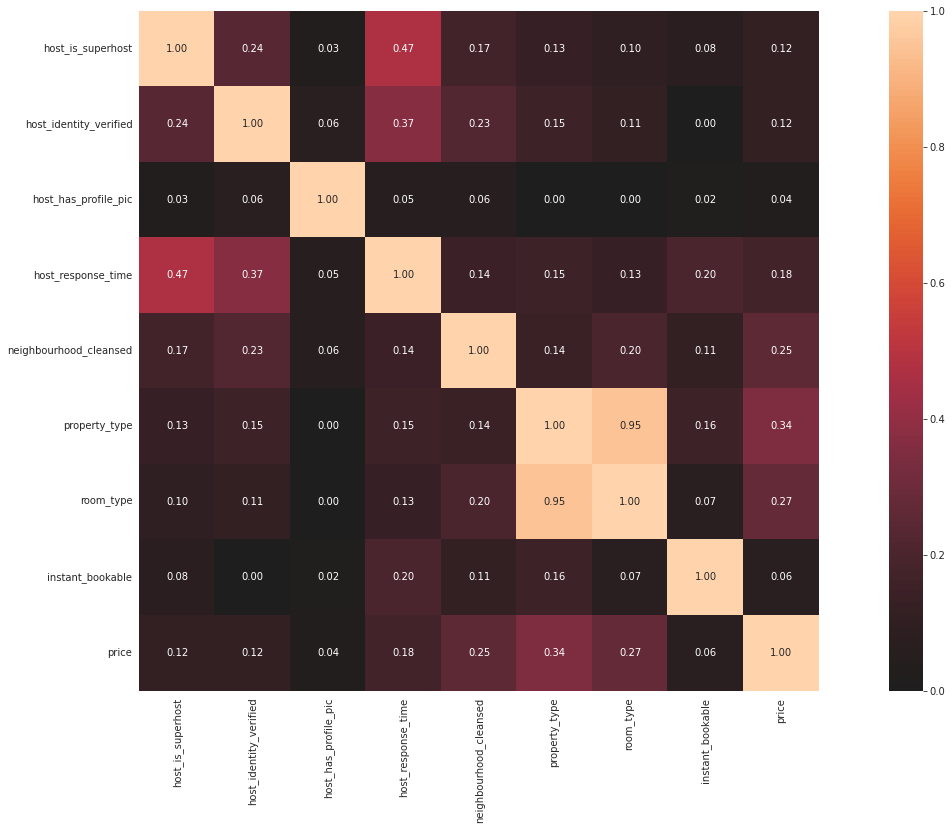

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f29c5448b90>,
 'corr':                         host_is_superhost  ...     price
 host_is_superhost                1.000000  ...  0.116124
 host_identity_verified           0.238490  ...  0.115846
 host_has_profile_pic             0.027277  ...  0.035854
 host_response_time               0.473254  ...  0.176602
 neighbourhood_cleansed           0.166381  ...  0.252370
 property_type                    0.131664  ...  0.344843
 room_type                        0.101280  ...  0.274127
 instant_bookable                 0.076792  ...  0.062955
 price                            0.116124  ...  1.000000
 
 [9 rows x 9 columns]}

In [55]:
categoricalCols = airbnb_df.select_dtypes(['object']).columns.to_list()

numericCols = airbnb_df.select_dtypes(['float64', 'int64']).columns.to_list()

associations(airbnb_df[categoricalCols + ['price']], figsize=PLOT_DIMENSIONS, nominal_columns=categoricalCols) 

## 4.2. Analisando features contínuas

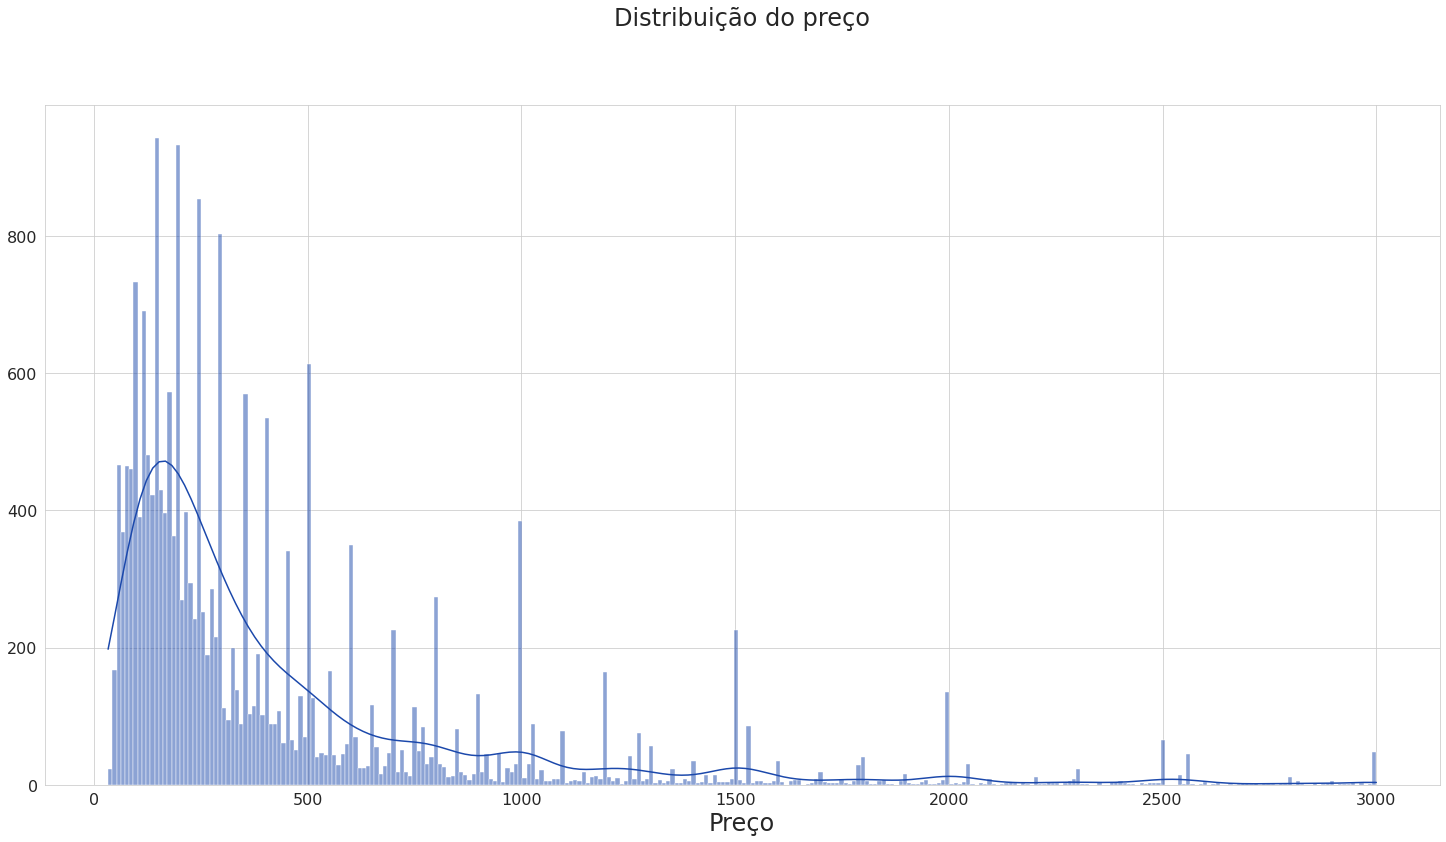

In [56]:
# Visualizando a distribuição dos preços 

fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)


sns.histplot(data=airbnb_df["price"], color=MAIN_COLOR, ax=ax, kde=True, bins=300)

plt.xlabel("Preço", fontsize=24)

plt.ylabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Distribuição do preço", pad=80, fontsize=24)

plt.show()

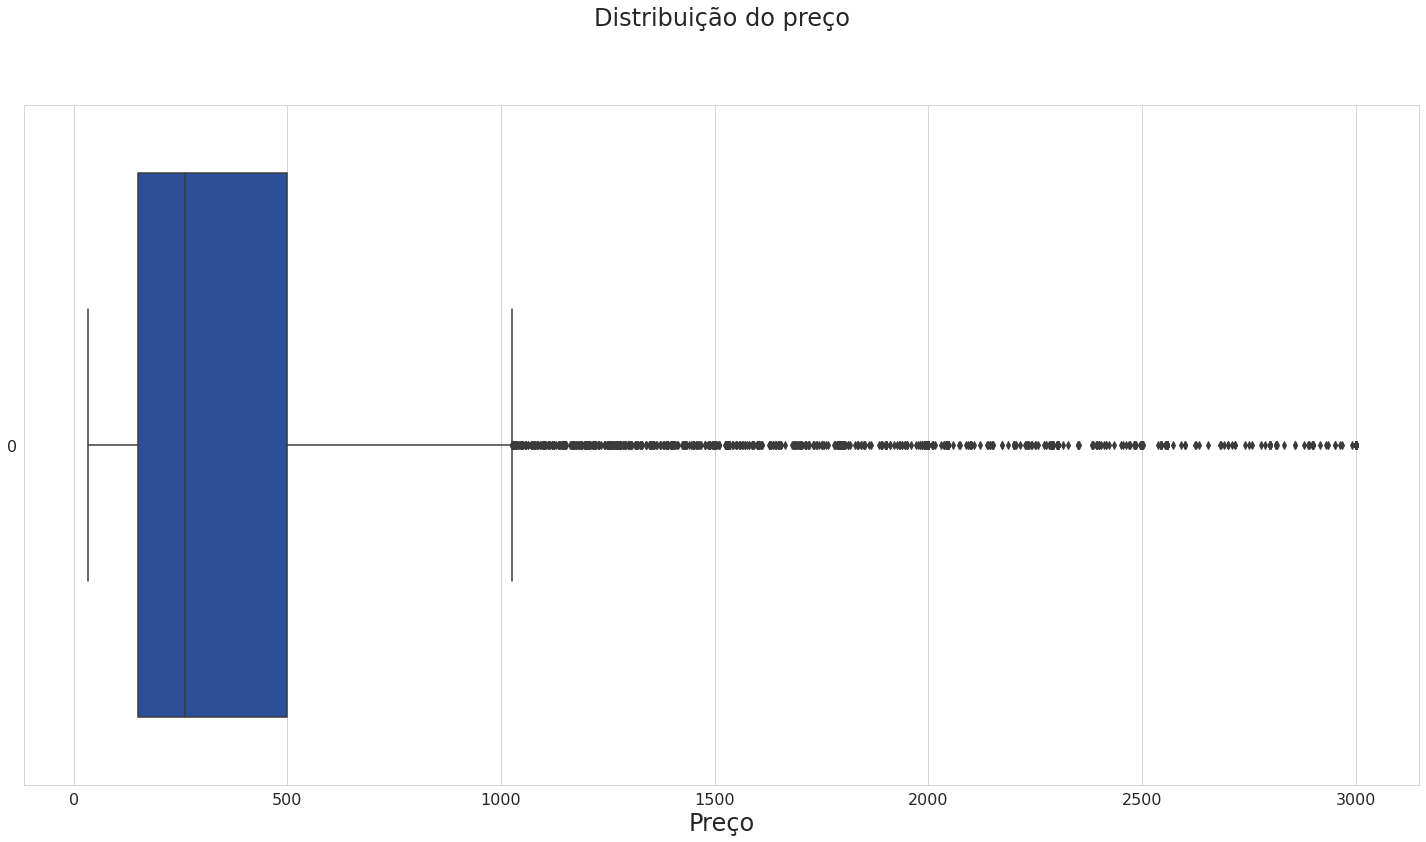

In [58]:
# Visualizando a distribuição dos preços 

fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

sns.boxplot(data=airbnb_df["price"], color=MAIN_COLOR, orient='h', ax=ax)

plt.xlabel("Preço", fontsize=24)

plt.ylabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Distribuição do preço", pad=80, fontsize=24)

plt.show()

In [66]:
# Visualizando os dados estatísticos do preço 

airbnb_df.price.describe()

count    21192.000000
mean       439.306200
std        473.713298
min         33.000000
25%        150.000000
50%        260.000000
75%        500.000000
max       3000.000000
Name: price, dtype: float64

### 4.2.1. Teste de hipótese

Uma das hipóteses iniciais diz que o preço possuí uma distribuição log-normal. Com isto, iremos utilizar o método de Kolmogorov-Smirnov para verificarmos se devemos ou não aceitar a Hipótese nula que diz respeito a semelhança entre a distribuição log-normal e a distribuição dos preços.

"Em estatística, o teste Kolmogorov–Smirnov (também conhecido como teste KS ou teste K–S) é um teste não paramétrico de bondade do ajuste sobre a igualdade de distribuições de probabilidade contínuas e unidimensionais que pode ser usado para comparar uma amostra com uma distribuição de probabilidade de referência (teste K–S uniamostral) ou duas amostras uma com a outra (teste K–S biamostral).[1] Recebe este nome em homenagem aos matemáticos russos Andrei Kolmogorov e Nikolai Smirnov. " - Wikipedia.

In [65]:
# Teste de hipótese

alpha = 0.05

ks_test = stats.kstest(airbnb_df["price"], "lognorm", scipy.stats.lognorm.fit(airbnb_df["price"]))

print(f"O p-value encontrado pelo método de KS: {ks_test.pvalue} \n")

print(f"A distribuição do logarítimo dos preços é {'Log-normal' if ks_test.pvalue > alpha else 'Não log-normal'}")

O p-value encontrado pelo método de KS: 6.010578228741865e-17 

A distribuição do logarítimo dos preços é Não log-normal


### 4.2.2. Analisando o impacto das features contínuas no preço

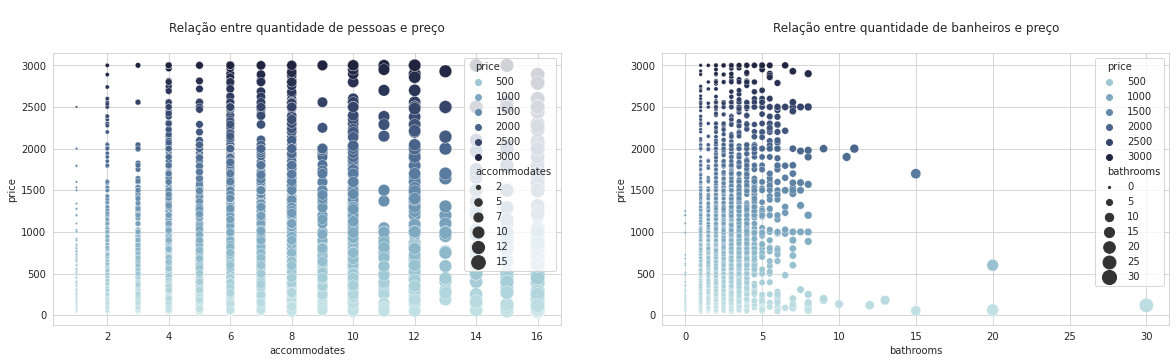

In [72]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

figs, axs = plt.subplots(figsize=(20, 5), ncols=2)

sns.scatterplot(x="accommodates", y="price", size='accommodates', sizes=(5, 200),
                      hue='price', palette=cmap,  data=airbnb_df, ax=axs[0])

axs[0].title.set_text('\nRelação entre quantidade de pessoas e preço\n')


sns.scatterplot(x="bathrooms", y="price", size='bathrooms', sizes=(5, 200),
                      hue='price', palette=cmap,  data=airbnb_df, ax=axs[1])

axs[1].title.set_text('\nRelação entre quantidade de banheiros e preço\n')





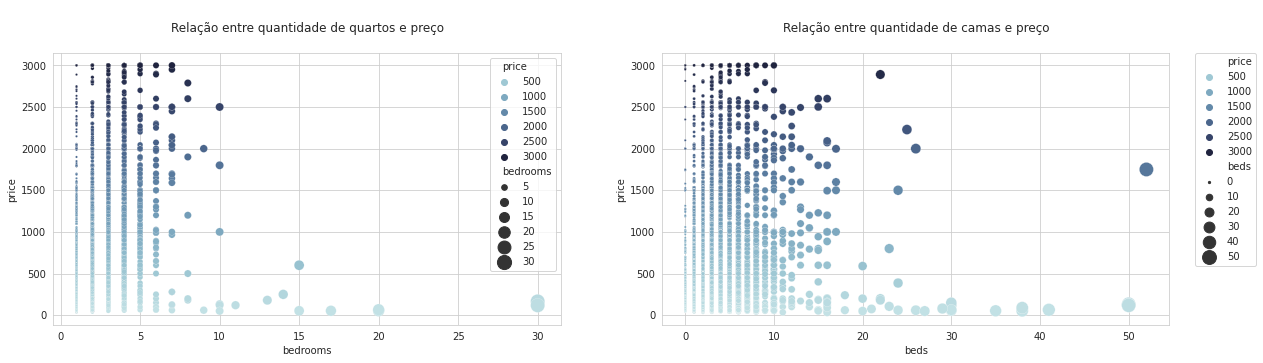

In [75]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

figs, axs = plt.subplots(figsize=(20, 5), ncols=2)

sns.scatterplot(x="bedrooms", y="price", size='bedrooms', sizes=(5, 200),
                      hue='price', palette=cmap,  data=airbnb_df, ax=axs[0])

axs[0].title.set_text('\nRelação entre quantidade de quartos e preço\n')

sns.scatterplot(x="beds", y="price", size='beds', sizes=(5, 200),
                      hue='price', palette=cmap,  data=airbnb_df, ax=axs[1])

axs[1].title.set_text('\nRelação entre quantidade de camas e preço\n')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

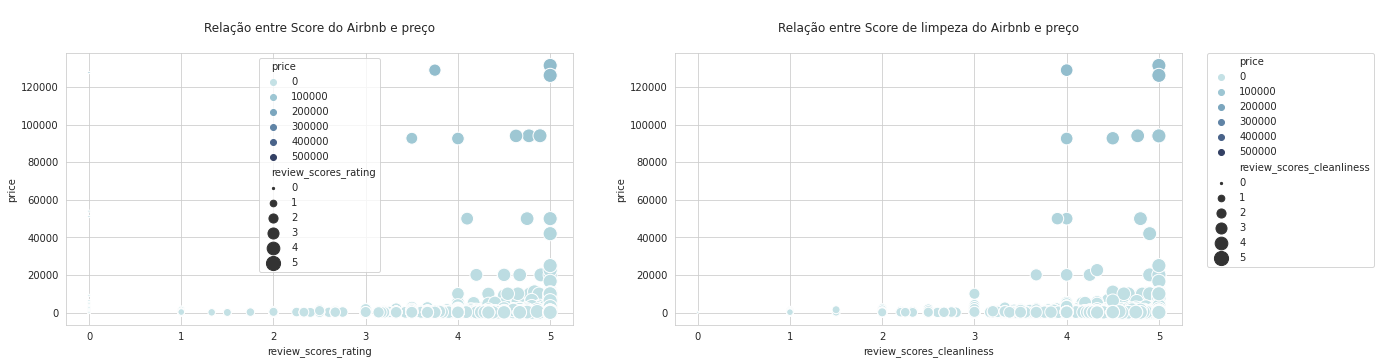

In [79]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

figs, axs = plt.subplots(figsize=(20, 5), ncols=2)

sns.scatterplot(x="review_scores_rating", y="price", size='review_scores_rating', sizes=(5, 200),
                      hue='price', palette=cmap,  data=df, ax=axs[0])

axs[0].title.set_text('\nRelação entre Score do Airbnb e preço\n')


sns.scatterplot(x="review_scores_cleanliness", y="price", size='review_scores_cleanliness', sizes=(5, 200),
                      hue='price', palette=cmap,  data=df, ax=axs[1])

axs[1].title.set_text('\nRelação entre Score de limpeza do Airbnb e preço\n')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);



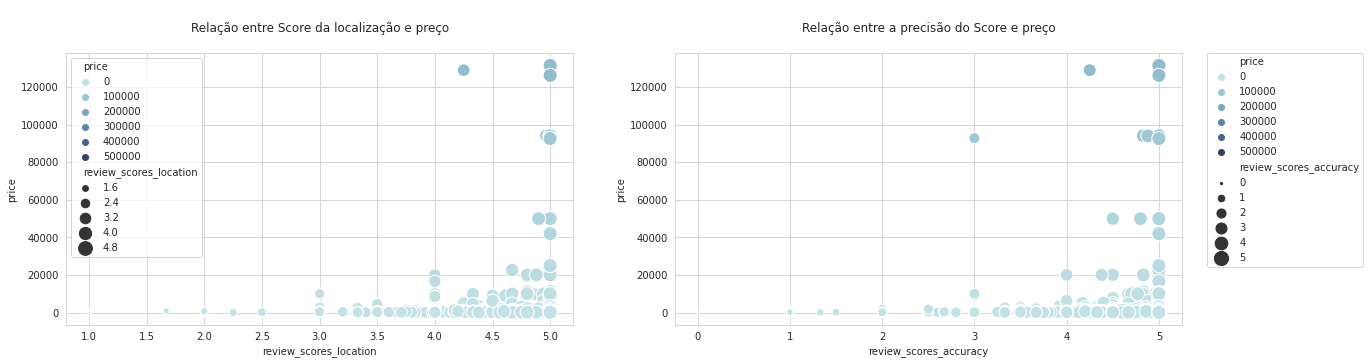

In [76]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

figs, axs = plt.subplots(figsize=(20, 5), ncols=2)

sns.scatterplot(x="review_scores_location", y="price", size='review_scores_location', sizes=(5, 200),
                      hue='price', palette=cmap,  data=df, ax=axs[0])

axs[0].title.set_text('\nRelação entre Score da localização e preço\n')

sns.scatterplot(x="review_scores_accuracy", y="price", size='review_scores_accuracy', sizes=(5, 200),
                      hue='price', palette=cmap,  data=df, ax=axs[1])

axs[1].title.set_text('\nRelação entre a precisão do Score e preço\n')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### 4.2.3. Clusterizando os preços

Neste momento iremos criar categorias para os preços através do algoritmo de clusterização K-Means. 

O primeiro passo é identificador o valor de K ótimo para o nosso problema, em seguida, iremos clusterizar estes preços e criar um label para cada cluster gerado a fim de facilitar a identificação. 

In [80]:
from sklearn.cluster import KMeans

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

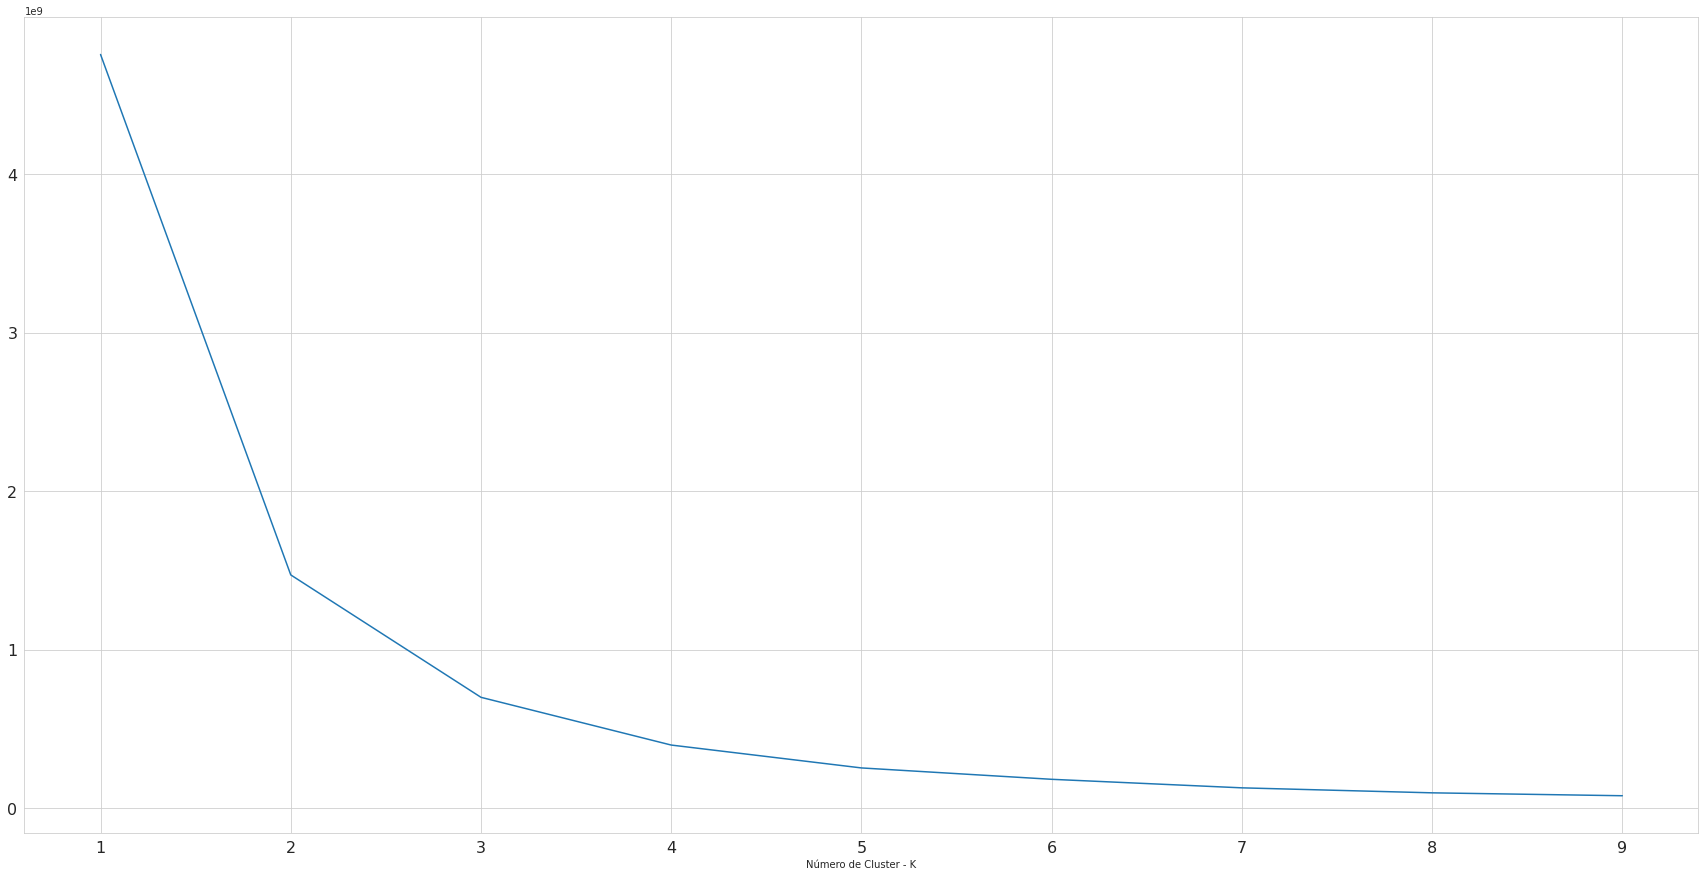

In [82]:
# Analisando o parâmetro k ideal para a clusterizaço


sse={} # Erro

price_df = airbnb_df[['price']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(price_df)

    # Nome dos clusters relativos ao valor da recência
    price_df["CLUSTERS"] = kmeans.labels_  

    # Erro correspondente aos clusters
    sse[k] = kmeans.inertia_ 



fig, ax = pyplot.subplots(figsize=(30, 15))

sns.lineplot(x=list(sse.keys()), y=list(sse.values()))

plt.xlabel("Número de Cluster - K")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.show()



Utilizaremos k = 4 para a clusterização do preço 


In [84]:
# Construindo 4 clusters para a recência e colocando no dataframe

kmeans = KMeans(n_clusters=4)

airbnb_df['cluster_price'] = kmeans.fit_predict(airbnb_df[['price']])

airbnb_df.head()

host_is_superhost host_identity_verified  ... private_entrance cluster_price
0                 f                      t  ...                1             0
1                 f                      t  ...                0             0
2                 f                      t  ...                0             0
3                 t                      t  ...                0             0
4                 t                      f  ...                0             0

[5 rows x 68 columns]

In [85]:
# Visualizando dados estatísticos da recência para cada cluster criado.

airbnb_df.groupby('cluster_price')['price'].describe()

count         mean         std  ...     50%     75%     max
cluster_price                                    ...                        
0              13444.0   187.213255   84.621757  ...   180.0   250.0   371.0
1               2066.0  1189.889158  229.578033  ...  1145.0  1400.0  1714.0
2               4985.0   555.659178  138.698437  ...   500.0   658.0   872.0
3                697.0  2244.777618  372.443092  ...  2100.0  2500.0  3000.0

[4 rows x 8 columns]

In [86]:
# Método que ordena o cluster

def order_cluster(cluster_field_name, target_field_name, df, ascending):
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()

    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)

    df_new['index'] = df_new.index

    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)

    df_final = df_final.drop([cluster_field_name],axis=1)

    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

In [89]:
# Ordenando os clusters da recência

airbnb_df = order_cluster('cluster_price', 'price', airbnb_df, True)

# Visualizando dados estatísticos da recência para cada cluster criado.

airbnb_df.groupby('cluster_price')['price'].describe()


count         mean         std  ...     50%     75%     max
cluster_price                                    ...                        
0              13444.0   187.213255   84.621757  ...   180.0   250.0   371.0
1               4985.0   555.659178  138.698437  ...   500.0   658.0   872.0
2               2066.0  1189.889158  229.578033  ...  1145.0  1400.0  1714.0
3                697.0  2244.777618  372.443092  ...  2100.0  2500.0  3000.0

[4 rows x 8 columns]

In [91]:
# Criando um label pra a melhor visualização dos dados relativos aos clusters da recência

airbnb_df['label_price'] = 'Alta'

airbnb_df.loc[airbnb_df['cluster_price'] == 0, 'label_price'] = 'Muito Baixa' 

airbnb_df.loc[airbnb_df['cluster_price'] == 1, 'label_price'] = 'Baixa' 

airbnb_df.loc[airbnb_df['cluster_price'] == 2, 'label_price'] = 'Média' 

price_cluster_values_count = airbnb_df['label_price'].value_counts(ascending=True)

In [92]:
# Visualizando a quantidade de Airbnb por categoria de preço 

price_cluster_values_count

Alta             697
Média           2066
Baixa           4985
Muito Baixa    13444
Name: label_price, dtype: int64

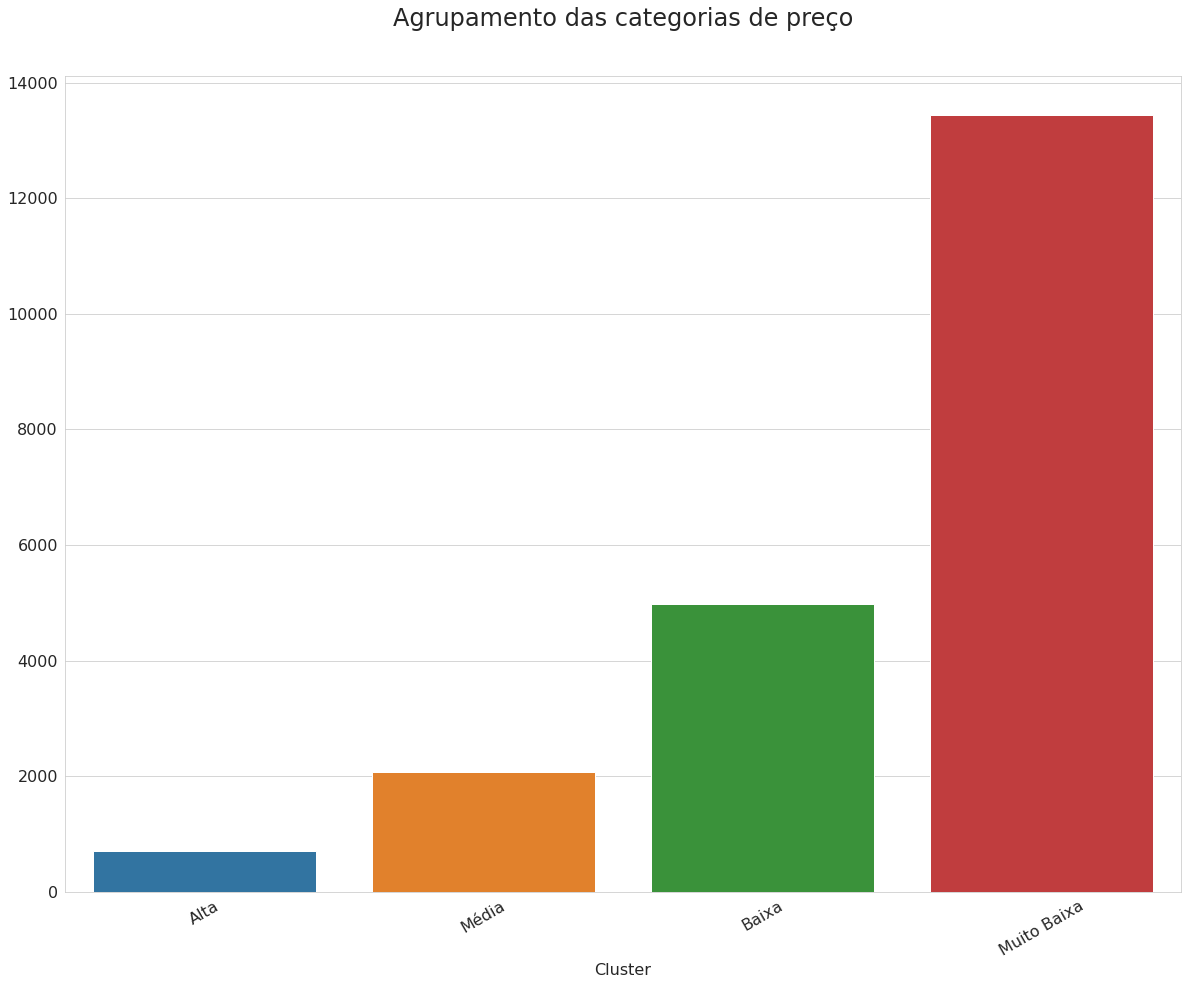

In [94]:
# Visualizando a quantidade de Airbnb por categoria de preço 

fig, ax = pyplot.subplots(figsize=(20, 15))

label_recency_plot = sns.barplot(x=price_cluster_values_count.index, y=price_cluster_values_count)

plt.ylabel("")

plt.xlabel("Cluster", fontsize=16)

plt.xticks(fontsize=16, rotation=30, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Agrupamento das categorias de preço", pad=50, fontsize=24)

plt.show(label_recency_plot)

### 4.2.4 Analisando a correlação das features contínuas

Analisando a correlação das variáveis numéricas utilizando o método Pearson's R.

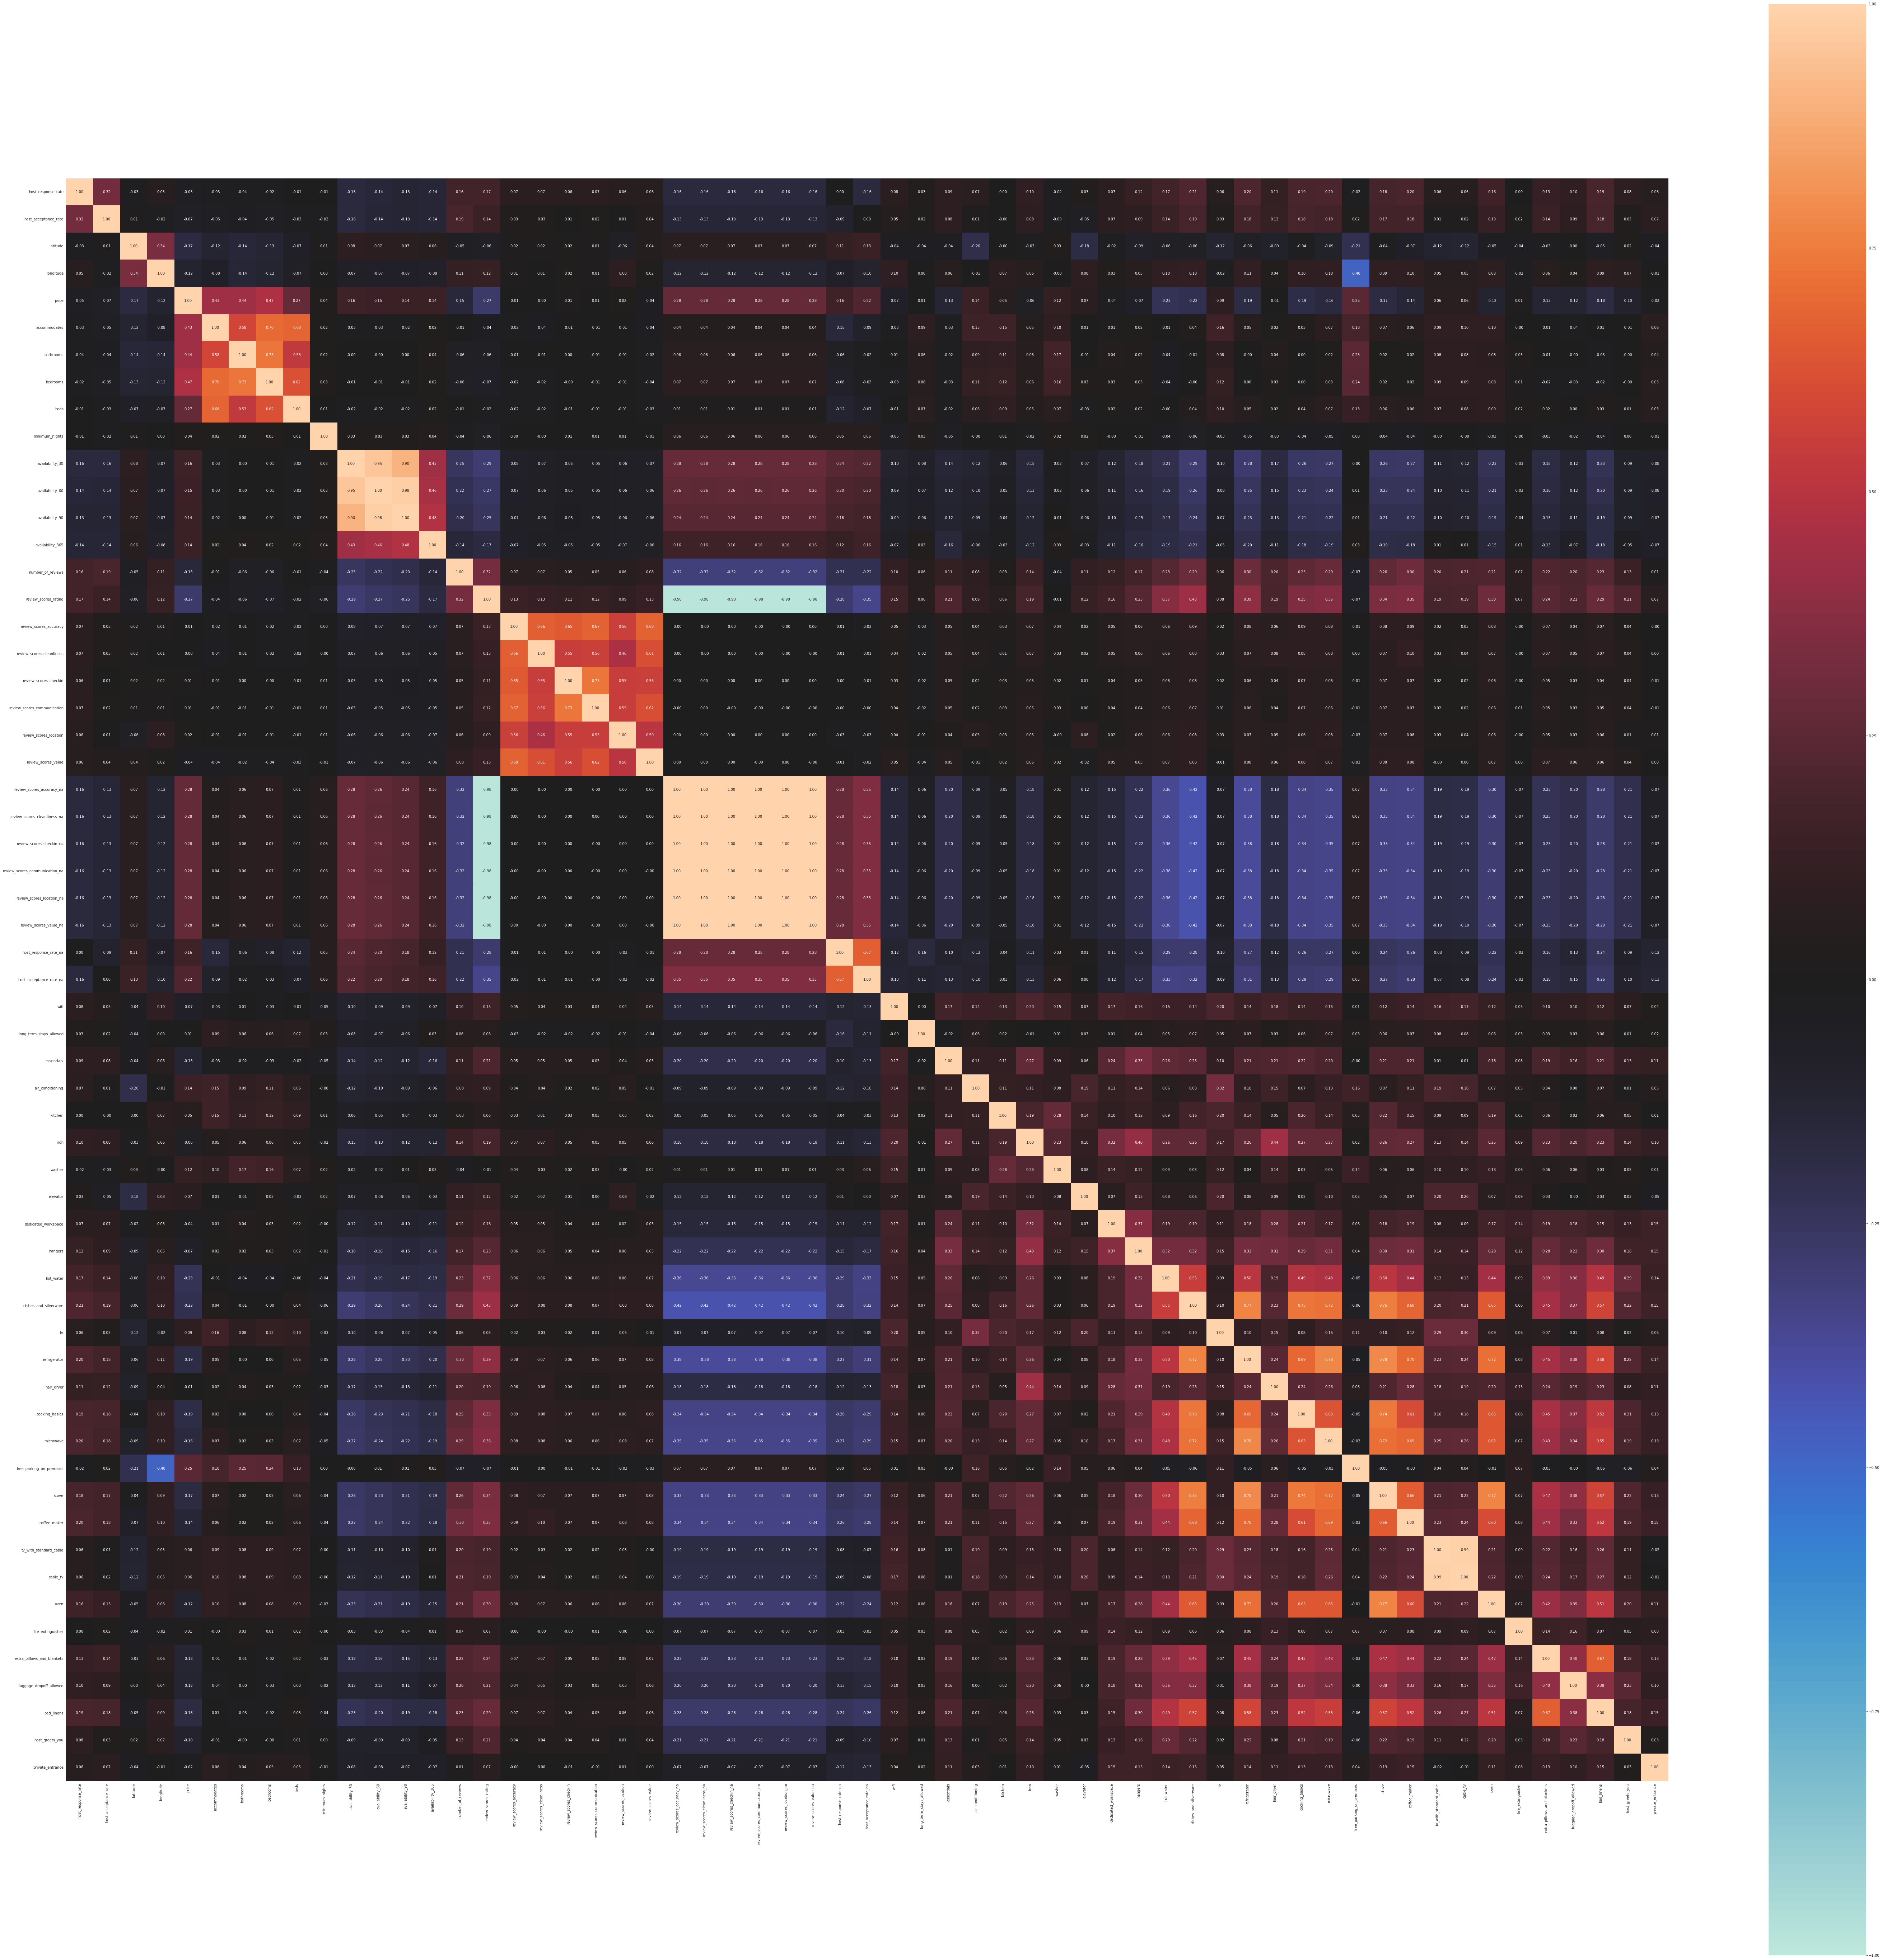

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f29c57dc8d0>,
 'corr':                                 host_response_rate  ...  private_entrance
 host_response_rate                    1.000000e+00  ...          0.062018
 host_acceptance_rate                  3.175319e-01  ...          0.073304
 latitude                             -2.941682e-02  ...         -0.043040
 longitude                             5.369193e-02  ...         -0.010635
 price                                -4.996740e-02  ...         -0.023417
 accommodates                         -3.049570e-02  ...          0.062894
 bathrooms                            -3.709457e-02  ...          0.044642
 bedrooms                             -1.985248e-02  ...          0.054657
 beds                                 -1.256651e-02  ...          0.050013
 minimum_nights                       -5.222011e-03  ...         -0.014009
 availability_30                      -1.638103e-01  ...         -0.084612
 availability_60          

In [107]:
associations(airbnb_df[numericCols], figsize=(100,100), numerical_columns=numericCols) 

# 5. Criando o modelo

In [159]:
# Pré-processamento
from sklearn.model_selection import train_test_split

# Métricas para avaliação
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Modelos
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Otimização
from sklearn.model_selection import GridSearchCV


In [151]:
# Transformando feature categóricas em features contínuas

categoricalCols = airbnb_df.select_dtypes(['object']).columns.to_list()

X_features_encoded = airbnb_df.dropna().drop("price", axis=1).apply(lambda x: x.astype('category')) 

# get dummies for all features but remove the first one(avoid multicollinearity) also called Dummy Variable Trap
X_features_encoded = pd.get_dummies(X_features_encoded, columns=categoricalCols, drop_first= True)

In [152]:
# Visualizando as features encodadas

X_features_encoded.head()

host_response_rate  ... label_price_Média
0              100.0  ...                 0
1              100.0  ...                 0
2               40.0  ...                 0
3              100.0  ...                 0
4              100.0  ...                 0

[5 rows x 251 columns]

In [136]:
# Método que avalia o modelo com base nos dados reais e de predição

def evaluateRegressor(true,predicted,message = "Test set"):
    MSE = mean_squared_error(true,predicted,squared = True)
    MAE = mean_absolute_error(true,predicted)
    RMSE = mean_squared_error(true,predicted,squared = False)
    R_squared = r2_score(true,predicted)
    print(message)
    print("MSE:", MSE)
    print("MAE:", MAE)
    print("RMSE:", RMSE)
    print("R-squared:", R_squared)



## 5.1 Regressão Linear

A fim de simplicidade, iremos validar como o modelo se comporta utilizando uma Regressão Linear simples. 

In [153]:
# Splitando os dados em teste e treinamento

X_train, X_test, y_train, y_test = train_test_split(X_features_encoded, airbnb_df.dropna()['price'], test_size=0.2, shuffle = True, random_state=1)

In [154]:
# Criando e treinando o modelo utilizando os dados de treinamento

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [155]:
# Prevendo o preço utilizando os dados de teste
predictions = model.predict(X_test)


In [156]:
# Avaliando o modelo com os dados de treinamento

print("Avaliando os dados de teste do método de Regressão Linear")

predicted_valid_y = model.predict(X_train)

evaluateRegressor(y_train,predicted_valid_y,"    Train Set")

Avaliando os dados de teste do método de Regressão Linear
    Train Set
MSE: 9687.610989340114
MAE: 68.65665912258305
RMSE: 98.42566224994431
R-squared: 0.919058278931461


In [157]:
# Avaliando o modelo com os dados de teste

print("Avaliando os dados de teste do método de Regressão Linear")

predicted_valid_y = model.predict(X_test)

evaluateRegressor(y_test,predicted_valid_y,"    Test Set")

Avaliando os dados de teste do método de Regressão Linear
    Test Set
MSE: 11312.958901352617
MAE: 73.44198639234038
RMSE: 106.36239420656446
R-squared: 0.901453202245803


## 5.2. Random Forest



In [164]:
# Otimização de hyperparâmetros com GridSearch
n_estimators = [100, 300, 500, 800, 1000]

max_depth = [5, 8, 16, 32, 64]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth)

forest = RandomForestRegressor(random_state = 42)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)

rfModel = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [166]:
# Avaliando o modelo com os dados de treinamento

print("Avaliando os dados de teste do método de Regressão Linear")

predicted_valid_y = rfModel.predict(X_train)

evaluateRegressor(y_train,predicted_valid_y,"    Train Set")

Avaliando os dados de teste do método de Regressão Linear
    Train Set
MSE: 1291.750078808498
MAE: 24.481149964709957
RMSE: 35.94092484631549
R-squared: 0.9892071972456129


In [165]:
# Avaliando o modelo com os dados de teste

print("Avaliando os dados de teste do método de Regressão Linear")

predicted_valid_y = rfModel.predict(X_test)

evaluateRegressor(y_test,predicted_valid_y,"    Test Set")

Avaliando os dados de teste do método de Regressão Linear
    Test Set
MSE: 9276.127245654117
MAE: 65.87220575763538
RMSE: 96.31265361132003
R-squared: 0.919195973079123


# 6. Conclusões

Como podemos perceber, o modelo de Regressão Linear em comparação com o modelo de Random Forest gerado é um bom modelo para predição de preços da diária de Airbnbs na cidade do Rio de Janeiro. Além disso, as features *bathrooms, bedrooms,accommodates, latitude e longitude* são as features mais importantes para o nosso modelo. 

Com o desenvolvimento foi percebido que os modelos de regressão utilizados são altamente influenciados por outliers, uma informação que ajudaria a resolver este problema seria o tamanho da locação, pois algumas locações possuem a mesma quantidade de banheiros, quartos, cama e localização porém se diferem no tamanho da propriedade o que acaba gerando uma grande discrepância nos preços - informação que não é repassada diretamente no dataset - entretando, quando limitados os preços para até R$2.000 reais temos um desempenho melhor na generalização do modelo. 

Vale ressaltar que, de fato, bairros mais próximo ao literal tendem a ter um maior valor médio e a maioria dos Airbnb se enquadram em um Cluster de preço que vão até o máximo R$ 1.000 o valor da diária. 

Estas análises tem muito valor tanto para quem quer viajar e encontrar um bom lugar com o melhor preço e para pessoas que pretendem colocar seu apartamento ou casa para locação no Airbnb saber a média de preço que ele pode cobrar de acordo com as características da locação. 
